# **Import Libraries 🌍**

In [1]:
!pip install opendatasets




import opendatasets as od
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **Downloading Dataset From Kaggle && Make Pre-Processing on it**

In [2]:
# Download the IMDB dataset using its Kaggle URL
dataset_url = "https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"
od.download(dataset_url)

Skipping, found downloaded files in "./imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


In [3]:
# Load dataset
df = pd.read_csv("./imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

# Convert sentiment labels to numerical values (0 = Negative, 1 = Positive)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

reviews = df['review'].values
labels = df['sentiment'].values

train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)

print(f"Total Reviews: {len(reviews)}")
print(f"Training Reviews: {len(train_reviews)}, Testing Reviews: {len(test_reviews)}")

Total Reviews: 50000
Training Reviews: 40000, Testing Reviews: 10000


# **Pad Sequence && Tokenizer**

In [4]:
vocab_size = 20000  # Number of unique words
max_length = 200  # Maximum sequence length
oov_token = "<OOV>"  # Out of vocabulary token

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_reviews)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(f"Original Review: {train_reviews[0]}")
print(f"Tokenized Sequence: {train_sequences[0]}")
print(f"Padded Sequence: {train_padded[0]}")
print(f"Training data shape: {train_padded.shape}, Labels: {train_labels.shape}")
print(f"Test data shape: {test_padded.shape}, Labels: {test_labels.shape}")

Original Review: That's what I kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. The comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. They are just badly written cyphers for the director to hang his multicultural beliefs on, a topic that has been done much better in other dramas both on TV and the cinema.<br /><br />I must confess, I'm not really one for spotting bad performances during a film, but it must be said that Nichola Burley (as the heroine's slutty best friend) and Wasim Zakir (as the nasty, bullying brother) were absolutely terrible. I don't know what acting school they graduated from, but if I was them I'd apply for a full refund post haste. Only Samina Awan in the lead role manages to impress in a cast of so-called British talent that we'll probably never hear from again. At least, that's the

# **Build the RNN model (using LSTM)**

In [5]:
embedding_dim = 64
rnn_units = 64

# Define LSTM Model
model= Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),  # Word embeddings
    LSTM(rnn_units, return_sequences=True),
    LSTM(rnn_units),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_padded, train_labels,
    epochs=50,
    batch_size=64,
    validation_data=(test_padded, test_labels),
    callbacks=[early_stop]
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 284ms/step - accuracy: 0.5359 - loss: 0.6851 - val_accuracy: 0.5039 - val_loss: 0.6939
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 282ms/step - accuracy: 0.5718 - loss: 0.6681 - val_accuracy: 0.8122 - val_loss: 0.4510
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 278ms/step - accuracy: 0.8527 - loss: 0.3663 - val_accuracy: 0.8684 - val_loss: 0.3096
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 277ms/step - accuracy: 0.9208 - loss: 0.2153 - val_accuracy: 0.8838 - val_loss: 0.2886
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 279ms/step - accuracy: 0.9521 - loss: 0.1421 - val_accuracy: 0.8822 - val_loss: 0.3001
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 265ms/step - accuracy: 0.9718 - loss: 0.0921 - val_accuracy: 0.8754 - val_loss: 0.3900


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8873 - loss: 0.2832

Test Accuracy: 0.8838


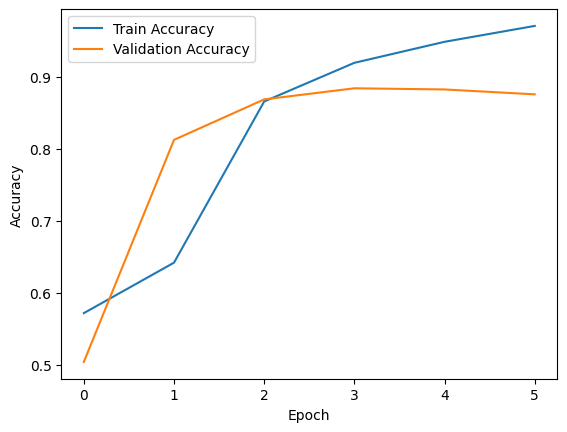

In [7]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"\nTest Accuracy: {test_acc:.4f}")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


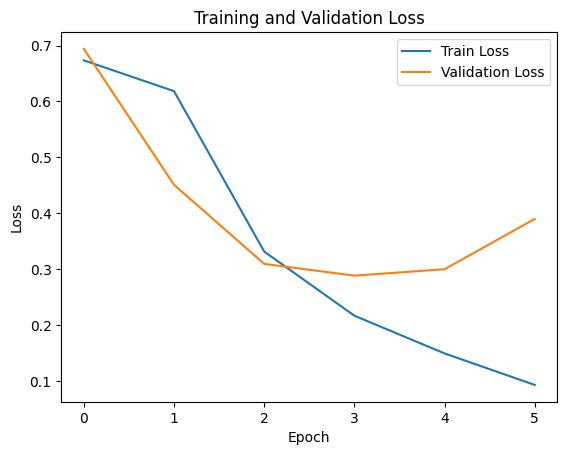

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


# **Sentiment Analysis on IMDB Movie Reviews Using LSTM**

In [10]:
# Function to preprocess custom text
def encode_text(text):
    words = text.lower().split()
    encoded = [tokenizer.word_index.get(word, 1) for word in words]
    padded = pad_sequences([encoded], maxlen=max_length, padding='post', truncating='post')
    return padded

def predict_sentiment(text):
    processed_text = encode_text(text)
    prediction = model.predict(processed_text)[0][0]  # Get probability
    sentiment = "Positive 😀" if prediction > 0.5 else "Negative 😞"
    print(f"\nReview: {text}")
    print(f"Sentiment: {sentiment}")

predict_sentiment("This movie was absolutely fantastic! I loved it.")
predict_sentiment("Worst movie ever. Completely disappointed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step

Review: This movie was absolutely fantastic! I loved it.
Sentiment: Positive 😀
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step

Review: Worst movie ever. Completely disappointed.
Sentiment: Negative 😞


In [11]:
user_review = input("Enter a movie review: ")
predict_sentiment(user_review)

Enter a movie review: The worst movie I have ever watched. Waste of time!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Review: The worst movie I have ever watched. Waste of time!
Sentiment: Negative 😞


In [12]:
predict_sentiment("Nothing about this movie worked. The pacing was slow, the jokes were unfunny, and the acting felt forced.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Review: Nothing about this movie worked. The pacing was slow, the jokes were unfunny, and the acting felt forced.
Sentiment: Negative 😞


# **Build the RNN model (using SIMPLE RNN)**

In [13]:
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dense(1, activation="sigmoid")
])

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history2 = model2.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_data=(test_padded, test_labels))


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 101ms/step - accuracy: 0.5026 - loss: 0.6967 - val_accuracy: 0.5133 - val_loss: 0.6923
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 95ms/step - accuracy: 0.5879 - loss: 0.6618 - val_accuracy: 0.5106 - val_loss: 0.7218
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.6750 - loss: 0.5346 - val_accuracy: 0.5100 - val_loss: 0.7244
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.6636 - loss: 0.5335 - val_accuracy: 0.5125 - val_loss: 0.8203
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 99ms/step - accuracy: 0.6837 - loss: 0.4803 - val_accuracy: 0.5121 - val_loss: 0.8563


# **Sentiment Analysis on IMDB Movie Reviews Using SIMPLE RNN**

In [16]:
def predict_sentiment2(text):
    processed_text = encode_text(text)
    prediction = model2.predict(processed_text)[0][0]
    sentiment = "Positive 😀" if prediction > 0.5 else "Negative 😞"
    print(f"\nReview: {text}")
    print(f"Sentiment: {sentiment}")

predict_sentiment2("This movie was absolutely fantastic! I loved it.")
predict_sentiment2("Worst movie ever. Completely disappointed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Review: This movie was absolutely fantastic! I loved it.
Sentiment: Positive 😀
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Review: Worst movie ever. Completely disappointed.
Sentiment: Positive 😀


In [17]:
predict_sentiment2("Nothing about this movie worked. The pacing was slow, the jokes were unfunny, and the acting felt forced.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Review: Nothing about this movie worked. The pacing was slow, the jokes were unfunny, and the acting felt forced.
Sentiment: Positive 😀
